In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
# sys.path.append("/home/pbagad/projects/")
sys.path.append("/home/fmthoker/")
sys.path.append("/home/fmthoker/ssl_benchmark/")
# sys.path.append("/home/pbagad/projects/ssl_benchmark/")

In [4]:
execfile("/home/pbagad/projects/ViDA-SSL/utils/viz.py")

In [5]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

In [6]:
from ssl_benchmark.datasets.ucf import UCF
from ssl_benchmark.datasets.ntu60 import NTU
from ssl_benchmark.datasets.gym import GYM99

from ssl_benchmark.utils.videotransforms import video_transforms, tensor_transforms, volume_transforms

### Load datasets

In [6]:
crop = (112, 112)

transforms = [
    video_transforms.Resize(int(crop[0]/0.875)),
    video_transforms.CenterCrop(crop),
    volume_transforms.ClipToTensor(),
    tensor_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

In [8]:
datasets = {
    "UCF": {
        "name": "UCF",
        "args": dict(
            subset="trainlist01",
            clips_per_video=1,
            video_fps=16.0,
            video_clip_duration=(1.0/16.0),
            video_transform=transforms,
            return_labels=True,
        )
    },
    "NTU": {
        "name": "NTU",
        "args": dict(
            subset="trainlist01",
            clips_per_video=1,
            video_fps=16.0,
            video_clip_duration=(1.0/16.0),
            video_transform=transforms,
            return_labels=True,
        )
    },
    "Gym99": {
        "name": "GYM99",
        "args": dict(
            subset="trainlist01",
            clips_per_video=1,
            video_fps=16.0,
            video_clip_duration=(1.0/16.0),
            video_transform=transforms,
            return_labels=True,
        )
    },
}

In [9]:
dataloaders = dict()

for key, dataset_dict in datasets.items():
    dataset = eval(dataset_dict['name'])(**dataset_dict['args'])
    dataloader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
        drop_last=False,
    )
    dataloaders[key] = dataloader

['A0xAXXysHUo_E_002184_002237_A_0035_0036.avi', 'AZ4wWG6Rcak_E_003643_003675_A_0024_0026.avi', 'AZ4wWG6Rcak_E_004073_004175_A_0053_0054.avi', 'AZ4wWG6Rcak_E_004073_004175_A_0054_0055.avi', 'AZ4wWG6Rcak_E_004073_004175_A_0061_0062.avi', 'AZ4wWG6Rcak_E_004209_004299_A_0087_0090.avi', 'AZ4wWG6Rcak_E_005608_005706_A_0024_0025.avi', 'AZ4wWG6Rcak_E_005608_005706_A_0045_0046.avi', 'AZ4wWG6Rcak_E_005608_005706_A_0096_0097.avi', 'AZ4wWG6Rcak_E_005726_005763_A_0003_0006.avi'] [93, 77, 43, 55, 43, 73, 43, 49, 73, 77]


In [10]:
dataloaders.keys()

dict_keys(['UCF', 'NTU', 'Gym99'])

### Load model

In [11]:
model = models.resnet18(pretrained=True)

In [12]:
model.fc = nn.Identity()

### Forward pass with batching

In [13]:
model = model.eval()

In [14]:
def model_features_for_given_dataset(model, dataset_key, dataloader):
    results = {
        "features": [],
        "labels": [],
        "latent": [],
    }

    iterator = tqdm(
        dataloader,
        desc=f"Computing features for {type(model).__name__} on {dataset_key}",
        bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
    )
    with torch.no_grad():
        for batch in iterator:
            # import ipdb; ipdb.set_trace()
            # frames = batch["frames"]
            # labels = batch["label"]
            frames, labels = batch

            # remove time dimension since number of frames 1
            frames = frames.squeeze(2)

            # forward pass
            features = model(frames)

            results["features"].append(features.cpu())
            results["labels"].append(labels.cpu())

    results["features"] = torch.cat(results["features"], dim=0)
    results["labels"] = torch.cat(results["labels"], dim=0)

    return results

In [15]:
results = dict()

for key, dataloader in dataloaders.items():
    dataset_results = model_features_for_given_dataset(model, key, dataloader)
    results[key] = dataset_results

Computing features for ResNet on Gym99: 100%|██████████| 321/321 [00:44<00:00,  7.19it/s]                                                  


In [17]:
results["UCF"]["features"].shape, results["NTU"]["features"].shape, results["Gym99"]["features"].shape

(torch.Size([9537, 512]), torch.Size([40320, 512]), torch.Size([20484, 512]))

In [ ]:
# save generated features
save_path = join(
    "/home/pbagad/expts/ViDA-SSL/features",
    '_'.join(list(results.keys())) + "_train" + "-" + "resnet18_single_frame.pt",
)

In [ ]:
torch.save(results, save_path)

### Apply dimensionality reduction

In [7]:
save_path = "/home/pbagad/expts/ViDA-SSL/features/UCF_NTU_Gym99_train-resnet18_single_frame.pt"

In [8]:
results = torch.load(save_path)

In [9]:
results.keys()

dict_keys(['UCF', 'NTU', 'Gym99'])

In [10]:
results["UCF"]["features"].shape, results["NTU"]["features"].shape

(torch.Size([9537, 512]), torch.Size([40320, 512]))

In [11]:
from sklearn.manifold import TSNE
from umap import UMAP

In [23]:
def apply_dimred(X=None, results=None, method="PCA", K=2):
    if X is None:
        assert results is not None
        X = results["features"]

    if method == "PCA":
        (U, S, V) = torch.pca_lowrank(X)
        Z = torch.matmul(X, V[:, :K])

    elif method == "TSNE":
        Z = TSNE(n_components=K).fit_transform(X.numpy())
        Z = torch.from_numpy(Z)

    elif method == "UMAP":
        Z = UMAP(n_neighbors=100, min_dist=0.3).fit_transform(X)
        Z = torch.from_numpy(Z)
    else:
        raise NotImplementedError
    
    return Z

In [24]:
method = "UMAP"

for key, subresults in results.items():
    print(f"Applying dimensionality-reduction for {key} features")
    Z = apply_dimred(results=subresults, method=method)
    results[key][f"latent-{method}"] = Z

Applying dimensionality-reduction for UCF features


/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Applying dimensionality-reduction for NTU features


/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Applying dimensionality-reduction for Gym99 features


/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


In [25]:
results["UCF"]["latent-TSNE"].shape

torch.Size([9537, 2])

In [26]:
torch.save(results, save_path)

### Perform combined dimensionality reduction

In [30]:
combined_features = torch.cat([results[key]["features"] for key in results])

In [31]:
combined_features.shape

torch.Size([70341, 512])

In [32]:
Z = apply_dimred(X=combined_features, method="UMAP")

/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


In [33]:
Z.shape

torch.Size([70341, 2])

In [34]:
num = 0
for key, subresults in results.items():
    Z_dataset = Z[num: num + subresults["features"].shape[0]]
    num += subresults["features"].shape[0]
    
    results[key]["joint_latent-UMAP"] = Z_dataset

In [35]:
torch.save(results, save_path)

### Visualize all datasets together

In [36]:
def dataset_df(dataset_key, subresults, latent_key="joint_latent"):
    df = pd.DataFrame(None)

    df["label"] = subresults["labels"].numpy()
    df["Z1"] = subresults[latent_key][:, 0].numpy()
    df["Z2"] = subresults[latent_key][:, 1].numpy()
    df["dataset"] = dataset_key
    
    return df

In [37]:
all_dfs = []
for key, subresults in results.items():
    df = dataset_df(key, subresults, "joint_latent-UMAP")
    all_dfs.append(df)

In [38]:
all_dfs = pd.concat(all_dfs)

In [39]:
all_dfs

,label,Z1,Z2,dataset
0,0,4.160082,4.478322,UCF
1,0,4.383567,4.602349,UCF
2,0,4.288184,4.600493,UCF
3,0,4.078506,4.578128,UCF
4,0,4.174558,4.598955,UCF
...,...,...,...,...
20479,1,4.561689,7.862944,Gym99
20480,3,5.381971,8.775596,Gym99
20481,1,5.759738,7.854734,Gym99
20482,4,4.880037,8.924886,Gym99


In [40]:
bokeh_2d_scatter_new(
    df=all_dfs, x="Z1", y="Z2", hue="dataset", label="label", use_nb=True, 
    title="[UMAP] ResNet18 feature embeddings for single-frame clips in UCF.", legend_loc="top_right"
)

Loading BokehJS ...

### Visualize each dataset

In [27]:
all_dfs = []
for key, subresults in results.items():
    df = dataset_df(key, subresults, latent_key="latent-UMAP")
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs)

In [28]:
bokeh_2d_scatter_new(
    df=all_dfs.loc[all_dfs.dataset == "Gym99"], x="Z1", y="Z2", hue="label", label="label", use_nb=True, 
    title="(TSNE) ResNet18 feature embeddings for single-frame clips in UCF.", legend_loc="top_right"
)

Loading BokehJS ...

/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
bokeh_2d_scatter_new(
    df=all_dfs.loc[all_dfs.dataset == "UCF"], x="Z1", y="Z2", hue="label", label="label", use_nb=True, 
    title="(TSNE) ResNet18 feature embeddings for single-frame clips in NTU.", legend_loc="top_right"
)

Loading BokehJS ...

/home/pbagad/install/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
from kmeans_pytorch import kmeans

In [63]:
K_values = [2, 5, 10, 30, 60, 100, 150, 200, 400, 500, 1000]
inertias = []

X = results["UCF"]["features"]
X = (X - X.mean()) / X.std()

for k in K_values:
    cluster_ids_x, cluster_centers = kmeans(
        X=X, num_clusters=k, distance='euclidean', device=torch.device('cuda:0')
    )
    inertia = torch.norm(X - cluster_centers[cluster_ids_x], p=2) / len(X)
    inertias.append(inertia.item())

running k-means on cuda:0..


[running kmeans]: 23it [00:00, 45.49it/s, center_shift=0.000083, iteration=23, tol=0.000100]


running k-means on cuda:0..


[running kmeans]: 28it [00:01, 26.99it/s, center_shift=0.000000, iteration=28, tol=0.000100]


running k-means on cuda:0..


[running kmeans]: 60it [00:04, 14.26it/s, center_shift=0.000000, iteration=60, tol=0.000100] 


running k-means on cuda:0..


[running kmeans]: 85it [00:14,  5.97it/s, center_shift=0.000000, iteration=85, tol=0.000100]   


running k-means on cuda:0..


[running kmeans]: 59it [00:18,  3.17it/s, center_shift=0.000000, iteration=59, tol=0.000100]   


running k-means on cuda:0..


[running kmeans]: 39it [00:19,  1.96it/s, center_shift=0.000000, iteration=39, tol=0.000100]    


running k-means on cuda:0..


[running kmeans]: 34it [00:25,  1.34it/s, center_shift=0.000000, iteration=34, tol=0.000100]    


running k-means on cuda:0..


[running kmeans]: 28it [00:27,  1.01it/s, center_shift=0.000000, iteration=28, tol=0.000100]    


running k-means on cuda:0..


[running kmeans]: 40it [01:18,  1.96s/it, center_shift=0.000000, iteration=40, tol=0.000100]     


running k-means on cuda:0..


[running kmeans]: 27it [01:05,  2.42s/it, center_shift=0.000000, iteration=27, tol=0.000100]     


running k-means on cuda:0..


[running kmeans]: 19it [01:31,  4.80s/it, center_shift=0.000000, iteration=19, tol=0.000100]     


In [64]:
inertias

[0.2144051045179367,
 0.20831486582756042,
 0.20327797532081604,
 0.19473837316036224,
 0.18945947289466858,
 0.18461720645427704,
 0.18107201159000397,
 0.17806445062160492,
 0.16851234436035156,
 0.16506856679916382,
 0.1510714739561081]

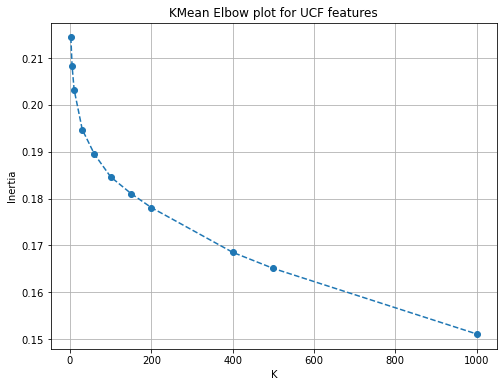

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.grid()
ax.set_title("KMean Elbow plot for UCF features")
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

ax.plot(K_values, inertias, '--o')
plt.show()